# 3.5.3 Gradient Boost Challenge

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

## Original Model before Feature Engineering

In [3]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [5]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [50,100,200],
              'learning_rate': [0.05,0.1,0.2],
          'max_depth': [5,6,7],
         'subsample': [0.8,1],
            'min_samples_split': [30,50,100],
            'min_weight_fraction_leaf': [0.02,0.05]}

clf_og = ensemble.GradientBoostingClassifier()
grid = GridSearchCV(estimator=clf_og, param_grid=parameters)
grid.fit(X_train, y_train)
print('Best Parameters: {}\nBest Score: {}'.format(grid.best_params_, grid.best_score_))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.02, 'n_estimators': 50, 'subsample': 0.8}
Best Score: 0.7538188761593017


In [6]:
# We'll use the best parameters from the GridSearchCV above to analyze errors.
params = {'n_estimators': 50,
          'max_depth': 5,
          'loss': 'deviance',
         'subsample': 0.8,
         'learning_rate': 0.05,
         'min_samples_split': 100,
         'min_weight_fraction_leaf': 0.02,}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train, train_tI_errors, train_tII_errors, score_test, test_tI_errors, test_tII_errors))


Training set accuracy:
R-squared Score: 0.7659574468085106
Percent Type I errors: 0.03968903436988543
Percent Type II errors: 0.19435351882160393

Test set accuracy:
R-squared Score: 0.7374233128834355
Percent Type I errors: 0.05276073619631902
Percent Type II errors: 0.2098159509202454


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

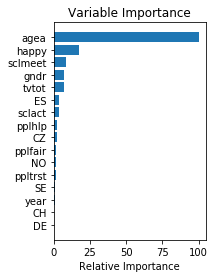

In [7]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner. 

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

## Feature Engineering
I will start by making some additional features.  To begin, I will inspect the boxplots of distributions of the variables for people with partners or not, and then report the t-values to determine whether or not the differences between the variables are significant.  

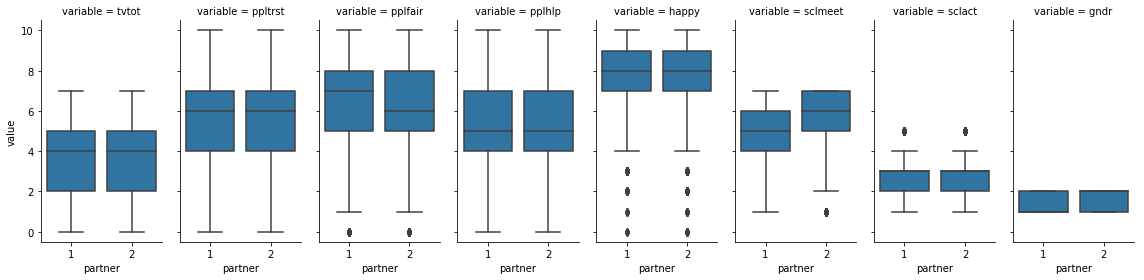

In [8]:
#setting up dataframe for boxplot of parters or no partners
dfl = df.drop(['agea', 'cntry', 'idno', 'year'], axis=1)
df_long = pd.melt(dfl, id_vars=['partner'])
g = sns.FacetGrid(df_long, col='variable', size=4, aspect=0.5)
g = g.map(sns.boxplot, 'partner', 'value', order=[1,2])
plt.show()

In [9]:
from scipy.stats import ttest_ind

for col in dfl.columns:
    t_val, p_val = ttest_ind(
        dfl[dfl['partner']==1][col],
        dfl[dfl['partner']==2][col])
    print('{}\t{}'.format(col, p_val))

tvtot	0.009292883328083916
ppltrst	0.0019168232030961356
pplfair	0.002110868444877708
pplhlp	0.04637745129936481
happy	1.471156645338203e-39
sclmeet	1.3276688249963506e-49
sclact	0.303332737769568
gndr	0.002156458353009423
partner	0.0


According to these boxplots, all variables are significantly different from one another, with the exception of social activities. For this reason, I will remove social activities from the feature set. It is also apparent from the boxplots that ratings for people with partners meeting people socially is significantly higher than for people without partners. 

In [10]:
X = X.drop(['sclact'], axis=1)

After inspecting the distributions of variables, I want to know if the variables are related to one another or not.  To achieve this, I will inspect the correlations between variables through a heat map to determine how related the variables are to one another.

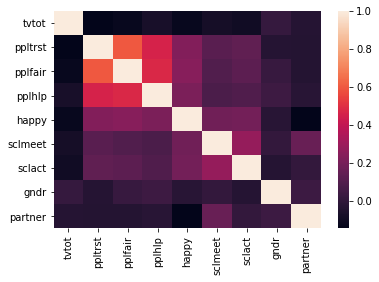

,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,partner
tvtot,1.000000,-0.142422,-0.119277,-0.069080,-0.118598,-0.078864,-0.092375,0.017922,-0.028816
ppltrst,-0.142422,1.000000,0.597506,0.459250,0.231533,0.122555,0.137491,-0.029921,-0.034371
pplfair,-0.119277,0.597506,1.000000,0.480931,0.247755,0.096501,0.128808,0.022251,-0.034054
pplhlp,-0.069080,0.459250,0.480931,1.000000,0.215323,0.080489,0.092673,0.042046,-0.022069
happy,-0.118598,0.231533,0.247755,0.215323,1.000000,0.182944,0.192030,-0.022413,-0.145061
sclmeet,-0.078864,0.122555,0.096501,0.080489,0.182944,1.000000,0.283319,0.009533,0.162970
sclact,-0.092375,0.137491,0.128808,0.092673,0.192030,0.283319,1.000000,-0.031648,0.011405
gndr,0.017922,-0.029921,0.022251,0.042046,-0.022413,0.009533,-0.031648,1.000000,0.033984
partner,-0.028816,-0.034371,-0.034054,-0.022069,-0.145061,0.162970,0.011405,0.033984,1.000000


In [11]:
corrmat = dfl.corr()
sns.heatmap(corrmat)
plt.show()
corrmat

In thinking about these variables, it would make sense that if people trust other people, they would also believe that people are fair and that people help them.  For this reason, I will engineer a feature that combines all three variables together. 

In [12]:
#combining variables related to trust, helpfulness, and fairness
X['ppltrst_pplhlp_pplfair'] = df['ppltrst'] * df['pplhlp'] * df['pplfair']
X = X.drop(['ppltrst', 'pplhlp', 'pplfair'], axis=1)

Now, using these engineered variables, I will finish getting the dataset ready for modeling and then separate the data into train and test datasets.

In [13]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

## Initial Model with Engineered Features

In [14]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': [50,100,200, 300],
              'learning_rate': [0.05,0.1,0.2],
          'max_depth': [5,6,7,8],
         'subsample': [0.8,1],
            'min_samples_split': [30,50,100],
            'min_weight_fraction_leaf': [0.02,0.05,0.1]}

clf = ensemble.GradientBoostingClassifier()
grid = GridSearchCV(estimator=clf, param_grid=parameters)
grid.fit(X_train, y_train)
print('Best Parameters: {}\nBest Score: {}'.format(grid.best_params_, grid.best_score_))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.02, 'n_estimators': 50, 'subsample': 0.8}
Best Score: 0.7534097108565194


In [15]:
# We'll use these best parameters for the engineered features to analyze errors.
params = {'n_estimators': 50,
          'max_depth': 5,
          'loss': 'deviance',
         'subsample': 0.8,
         'learning_rate': 0.05,
         'min_weight_fraction_leaf': 0.02,
         'min_samples_split': 30}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'R-squared Score: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(score_train, train_tI_errors, train_tII_errors, score_test, test_tI_errors, test_tII_errors))


Training set accuracy:
R-squared Score: 0.766366612111293
Percent Type I errors: 0.04064375340971085
Percent Type II errors: 0.19298963447899617

Test set accuracy:
R-squared Score: 0.7374233128834355
Percent Type I errors: 0.053987730061349694
Percent Type II errors: 0.2085889570552147


This optimized model reduced the percent of type 1 (false positive) errors in the test set by 0.2% to 5.39%.  This model did decrease the percent of type 2 (false negative) errors in the test set by about 0.08% to 20.85%.  The overall R-squared value for the test set remained approximately the same at 73.7%

Let's now inspect the different features for their importances in the best model from the grid search cv.

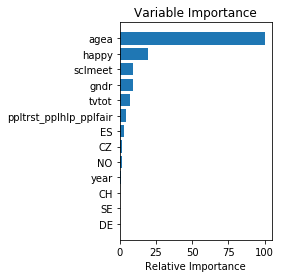

In [16]:
feature_importance2 = clf.feature_importances_

# Make importances relative to max importance.
feature_importance2 = 100.0 * (feature_importance2 / feature_importance2.max())
sorted_idx2 = np.argsort(feature_importance2)
pos2 = np.arange(sorted_idx2.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos2, feature_importance2[sorted_idx2], align='center')
plt.yticks(pos2, X.columns[sorted_idx2])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

According to the best model, again, age and happiness are the two greatest indicators of a person's relationship status.   This model has been optimized for the data set and is a good predictor of a peron's relationship status. 